# Modelowanie układów przepływowych - ćwiczenia 
### (budowa solwera równań płytkiej wody na bazie pakietu PyMPDATA)

# Setup

## Imports

In [ ]:
from typing import Any

import numpy as np
import pint
from cycler import cycler
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from numpy import dtype, float64, ndarray
from open_atmos_jupyter_utils import show_anim, show_plot
from PyMPDATA import (
    Options,
    ScalarField,
    Solver,
    Stepper,
    VectorField,
    boundary_conditions,
)
from PyMPDATA.scalar_field import ScalarField
from PyMPDATA.solver import Solver

plt.style.use(
    [
        # "science",
        # "grid",
        "notebook",
        "high-vis",
        # "default",
        # "dark_background",
    ]
)
nice_colors = [
    "royalblue",
    "darkorange",
    "mediumseagreen",
    "crimson",
    "mediumpurple",
    "sienna",
    "hotpink",
    "slategray",
    "goldenrod",
    "turquoise",
]
plt.rcParams["text.usetex"] = True
plt.rcParams["axes.prop_cycle"] = cycler(color=nice_colors)

## Config

In [110]:
class SI:
    ureg = pint.UnitRegistry()
    Q_ = ureg.Quantity
    ureg.formatter.default_format = "~P"


class Config:
    si = SI()

    @property
    def scalar_formatter(self) -> ScalarFormatter:
        formatter = ScalarFormatter()
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))
        return formatter


cfg = Config()

# Code

## 1. Opis układu: symbole i równania

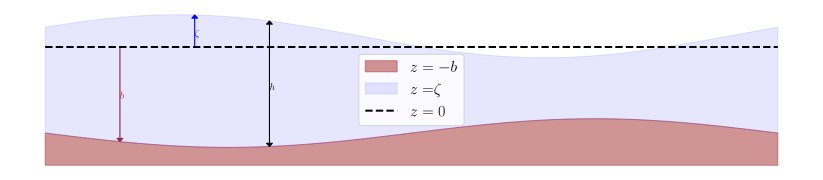

In [111]:
plt.figure(figsize=(14.5, 3))
plt.axis("off")

x = np.linspace(-np.pi, np.pi)
z = np.cos(x + 2) / 2 + 0.25
b = np.sin(x) / 3 - 2

arrow_kwargs = {"length_includes_head": True, "head_width": 0.05}

ix = 5
color = "brown"
label = "$b$"
plt.fill_between(x, b, -2.75, color=color, label=f"$z=-${label}", alpha=0.5)
plt.arrow(x[ix], 0, 0, b[ix], color=color, **arrow_kwargs)
plt.annotate(f" {label}", xy=(x[ix], b[ix] + 1), color=color)

ix = 10
color = "blue"
label = r"$\zeta$"
plt.fill_between(x, z, b, color=color, label=f"$z=${label}", alpha=0.1)
plt.arrow(x[ix], 0, 0, z[ix], color=color, **arrow_kwargs)
plt.annotate(f" {label}", xy=(x[ix], z[ix] - 0.5), color=color)

ix = 15
color = "black"
label = "$h$"
plt.plot(x, np.full_like(x, 0), linestyle="--", color=color, label="$z=0$")
plt.arrow(x[ix], 0, 0, z[ix], color=color, **arrow_kwargs)
plt.arrow(x[ix], 0, 0, b[ix], color=color, **arrow_kwargs)
plt.annotate(f" {label}", xy=(x[ix], -1), color=color)

plt.legend(loc=10)
show_plot("symbols")

$ \zeta(t; x,y) \rightarrow \text{wysokość swobodnej powierzchni względem geoidy (z=0)}$
$ b(x,y) \rightarrow \text{batymetria mierzona dodatnio w doół od geoidy}$
$ h(t; x,y) = \zeta + b \rightarrow \text{całkowita głębokość kolumny wody} $
$ \vec{u} = [u, v]$
$
\begin{cases}
  \partial_t h &=&\! -\nabla \cdot (\vec{u}h)\\
  \partial_t (hu) &=&\! -\nabla \cdot (\vec{u}hu) - gh\partial_x\zeta \\
  \partial_t (hv) &=&\! -\nabla \cdot (\vec{u}hv) - gh\partial_y\zeta
\end{cases}
$

## 2. Solver zbudowany na bazie PyMPDATA

In [112]:
class ShallowWaterEquationsIntegrator:

    def __init__(
        self,
        *,
        h_initial: ndarray[tuple[int, ...], dtype[float64]],
        options: Options | None = None,
        bathymetry: ndarray[tuple[int, ...], dtype[float64]],
    ) -> None:
        """initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0"""
        self.bathymetry = bathymetry
        options = options or Options(
            nonoscillatory=True,
            infinite_gauge=True,
        )
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(
            options=options,
            grid=grid,
            # n_threads=1, # kiedy numba nie działa, bo nie działa wielowątkowość
        )
        kwargs = {
            "boundary_conditions": [boundary_conditions.Constant(value=0)] * len(grid),
            "halo": options.n_halo,
        }
        advectees: dict[str, ScalarField] = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(np.zeros(grid), **kwargs),
            "vh": ScalarField(np.zeros(grid), **kwargs),
        }
        self.advector = VectorField(
            (np.zeros((grid[X] + 1, grid[Y])), np.zeros((grid[X], grid[Y] + 1))),
            **kwargs,
        )
        self.solvers: dict[str, Solver] = {
            k: Solver(stepper, v, self.advector) for k, v in advectees.items()
        }

    def __getitem__(self, key) -> ndarray[tuple[Any, ...], dtype[Any]]:
        """returns `key` advectee field of the current solver state"""
        return self.solvers[key].advectee.get()

    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy) -> None:
        """applies half of the source term in the given direction"""
        self[key][:] -= (
            0.5
            * g_times_dt_over_dxy
            * self["h"]
            * np.gradient(self["h"] - self.bathymetry, axis=axis)
        )

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy) -> None:
        """computes the Courant number component from fluid column height and momenta fields"""
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self["h"], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None)
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = (
            velocity[
                (
                    (all_but_last, all),
                    (all, all_but_last),
                )[axis]
            ]
            + np.diff(velocity, axis=axis) / 2
        )
        courant_number = self.advector.get_component(axis)[
            ((all_but_first_and_last, all), (all, all_but_first_and_last))[axis]
        ]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(
        self,
        *,
        nt: int,
        g: float,
        dt_over_dxy: tuple,
        outfreq: int,
        eps: float = 1e-7,
    ) -> dict[str, list[Any]]:
        """integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s]"""
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1):
            if it != 0:
                mask = self["h"] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(
                        axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy
                    )
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(
                        key=key,
                        axis=axis,
                        g_times_dt_over_dxy=g * dt_over_dxy[axis],
                    )
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(
                        key=key,
                        axis=axis,
                        g_times_dt_over_dxy=g * dt_over_dxy[axis],
                    )
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

## 3. Symulacja

In [113]:
grid = (50, 40)
bathymetry = np.tile(np.linspace(0, 1, grid[1]), (grid[0], 1))


h_initial = bathymetry.copy()
h_initial[
    grid[0] // 2 - grid[0] // 20 : grid[0] // 2 + grid[0] // 20,
    grid[1] // 2 - grid[1] // 20 : grid[1] // 2 + grid[1] // 20,
] += (
    0.025 * 3
)

output = ShallowWaterEquationsIntegrator(h_initial=h_initial, bathymetry=bathymetry)(
    nt=60, g=10, dt_over_dxy=(0.25, 0.25), outfreq=3
)

## 4. Wizualizacja


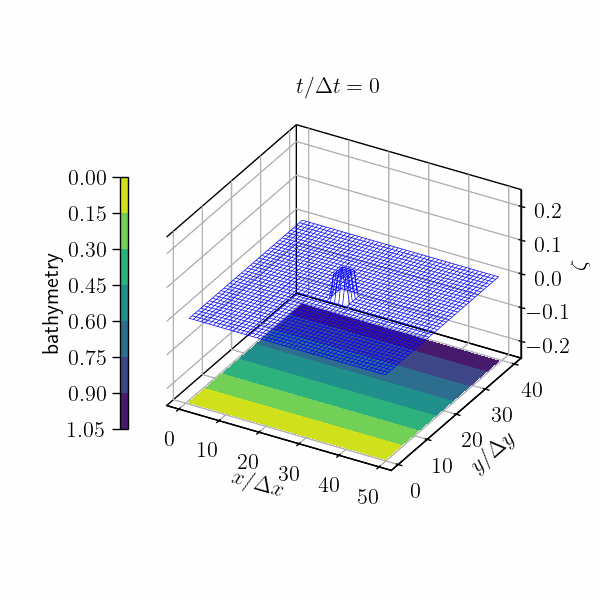

HTML(value="<a href='.\\anim.gif' target='_blank'>.\\anim.gif</a><br>")

In [146]:
def plot(frame, *, zlim=(-0.25, 0.25)):
    psi = output["h"][frame] - bathymetry
    xi, yi = np.indices(psi.shape)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6, 6))
    fig.subplots_adjust(left=0.2)
    ax.plot_wireframe(xi + 0.5, yi + 0.5, psi, color="blue", linewidth=0.5)
    ax.set(
        zlim=zlim,
        proj_type="ortho",
        title=rf"$t / \Delta t = {frame}$",
        zlabel=r"$\zeta$",
    )
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor("black")
        axis.pane.set_alpha(1)
    for axis in ("x", "y"):
        getattr(ax, f"set_{axis}label")(rf"${axis} / \Delta {axis}$")
    plt.colorbar(
        ax.contourf(
            xi + 0.5, yi + 0.5, bathymetry, zdir="z", offset=zlim[0], cmap="viridis_r"
        ),
        pad=0.02,
        aspect=30,
        fraction=0.02,
        label="bathymetry",
        location="left",
    ).ax.invert_yaxis()
    return fig


show_anim(plot, range(len(output["h"])), gif_file="anim.gif")

## Projekt zaliczeniowy 

#### sprawozdanie: obliczenia, wizualizacje i kompilacja pdf na GitHub Actions (pdf jako artefakt, maksimum 3 strony tekstu, w tym maksimum połowa to rysunki)

- fizyka/numeryka:
  - określ i opisz układ i parametry symulacji (warunek początkowy, batymetria, siatka, parametry fizyczne)
  - zdefiniuj pytanie, na które szukasz odpowiedzi (np. zależność wysokości fali przy brzegu od ...)
  - sprawdź i udokumentuj analizę zależności wyników od podwojenia rozdzielczości czasowej i przestrzennej
- wizualizacja:
  - pole (wektorowe) prędkości
  - powierzchnia płynu (zarówno 2D, jak i przekroje)
  - wyłącznie grafika wektorowa

#### Sposób wysłania
- w ciągu tygodnia: zgłoszenie przez UPEL pytania, na które będziemy poszukiwać odpowiedzi
- w ciągu dwóch tygodni: wrzucenie przez UPEL odnośnika do "runu" generującego artefakt ze sprawozdaniem (/actions/runs/...), który pozwala oceniającym jednoznacznie zlokalizować kod oraz logi wykonania symulacji.

#### Sposób oceny
- 25% fizyka (opis modelu, opis układu i parametrów)
- 25% numeryka (opis siatki, analiza zbieżności)
- 25% technikalia (odtwarzalność, jakość wykresów i poprawność opisów osi, czytelność kodu)
- 10% + 15% postawienie pytania i interpretacja wyników